This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import wispshapes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [6.0, 3.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stars=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

In [61]:
cands=wisps.datasets['candidates']

In [ ]:
colors=cands.spt.

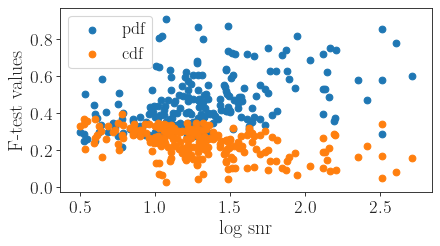

In [65]:
plt.scatter(cands.snr1.apply(np.log10), cands.f_test.values, label='pdf')
plt.scatter(cands.snr1.apply(np.log10), cands.f_test_cdf.values, label='cdf')
plt.xlabel("log snr")
plt.ylabel(" F-test values")
plt.legend()

In [5]:
cands.f_test_cdf.max()

0.3964477609553519

In [7]:
dt=stars[(stars.f_test_cdf<0.35) & (stars.snr1>=3.)].reset_index(drop=True)

In [8]:
len(dt), len(stars[stars.f_test< 0.35])

(3882, 101549)

In [9]:
gbhio=sel_crt.save_criteria(conts=dt)

  0%|          | 0/45 [00:00<?, ?it/s]

(2671, 26) (27, 26)


100%|██████████| 45/45 [02:03<00:00,  2.27s/it]


In [10]:
crts=sel_crt.crts_from_file()

In [11]:
#crts

In [12]:
#for idx in crts.values(): idx.plot(save=True)

In [13]:
compl=pd.DataFrame([x.completeness for x in crts.values()], index=[x.name for x in crts.values()])
cont=pd.DataFrame([x.contamination for x in crts.values()], index=[x.name for x in crts.values()])

In [14]:
def return_best_index(spt_range):
    return cont[cont[spt_range]<=cont[spt_range].min()+0.002][spt_range]

In [15]:
for x in cont.columns:
    print (return_best_index(x), " \n")

H_2O-1/J-Cont H-cont/J-Cont    0.03864
Name: L0-L5, dtype: float64  

H_2O-1/J-Cont CH_4/H_2O-2    0.085008
Name: L5-T0, dtype: float64  

H_2O-1/J-Cont CH_4/J-Cont    0.17491
Name: M7-L0, dtype: float64  

H_2O-1/J-Cont CH_4/H_2O-1      0.213292
H_2O-1/J-Cont H-cont/J-Cont    0.212519
Name: T0-T5, dtype: float64  

H_2O-1/J-Cont H_2O-2/J-Cont    0.003864
H_2O-1/J-Cont CH_4/H-Cont      0.003864
H-cont/J-Cont CH_4/H-Cont      0.005667
Name: T5-T9, dtype: float64  

H_2O-1/J-Cont H_2O-2/H_2O-1    0.000773
H_2O-1/J-Cont H_2O-2/J-Cont    0.000773
H_2O-1/J-Cont CH_4/J-Cont      0.000515
H_2O-1/J-Cont CH_4/H-Cont      0.000515
H_2O-2/J-Cont CH_4/H-Cont      0.001546
Name: Y dwarfs, dtype: float64  

H_2O-1/J-Cont H-cont/H_2O-1    0.043277
H_2O-1/J-Cont H-cont/J-Cont    0.045080
Name: subdwarfs, dtype: float64  

H_2O-1/J-Cont CH_4/H-Cont    0.378413
Name: trash, dtype: float64  



In [16]:
to_use={'H_2O-1/J-Cont CH_4/H-Cont':'L0-L5',
        'CH_4/H_2O-1 CH_4/H-Cont':'L5-T0' ,
        'H_2O-2/J-Cont CH_4/J-Cont':'M7-L0',
        'H-cont/H_2O-2 CH_4/H_2O-2': 'T0-T5',
        'H_2O-2/J-Cont CH_4/H-Cont': 'T5-T9',
        'H_2O-1/J-Cont CH_4/J-Cont': 'Y dwarfs'}
        

In [17]:
good_indices=[crts[k] for k in to_use.keys()]

In [18]:
[x.shape_name for x in good_indices[4].shapes]

['L0-L5', 'L5-T0', 'M7-L0', 'T0-T5', 'T5-T9', 'subdwarfs', 'trash', 'Y dwarfs']

In [19]:
def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [20]:
#for idx, k in zip(good_indices, to_use.keys()):
#    spt_range=to_use[k][0]
#    box_parameters(idx, spt_range)

In [21]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 'small'


In [22]:
#idx=good_indices[0]

In [23]:
#idx.contaminants[[idx.ykey, idx.ykey]].applymap(float).round(2)

In [24]:
spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)

In [25]:
subdwarfs=wisps.Annotator.reformat_table(good_indices[0]._subdwarfs).reset_index(drop=True)

In [26]:
good_indices[0].shapes

[box, box, box, box, box, box, box, box]

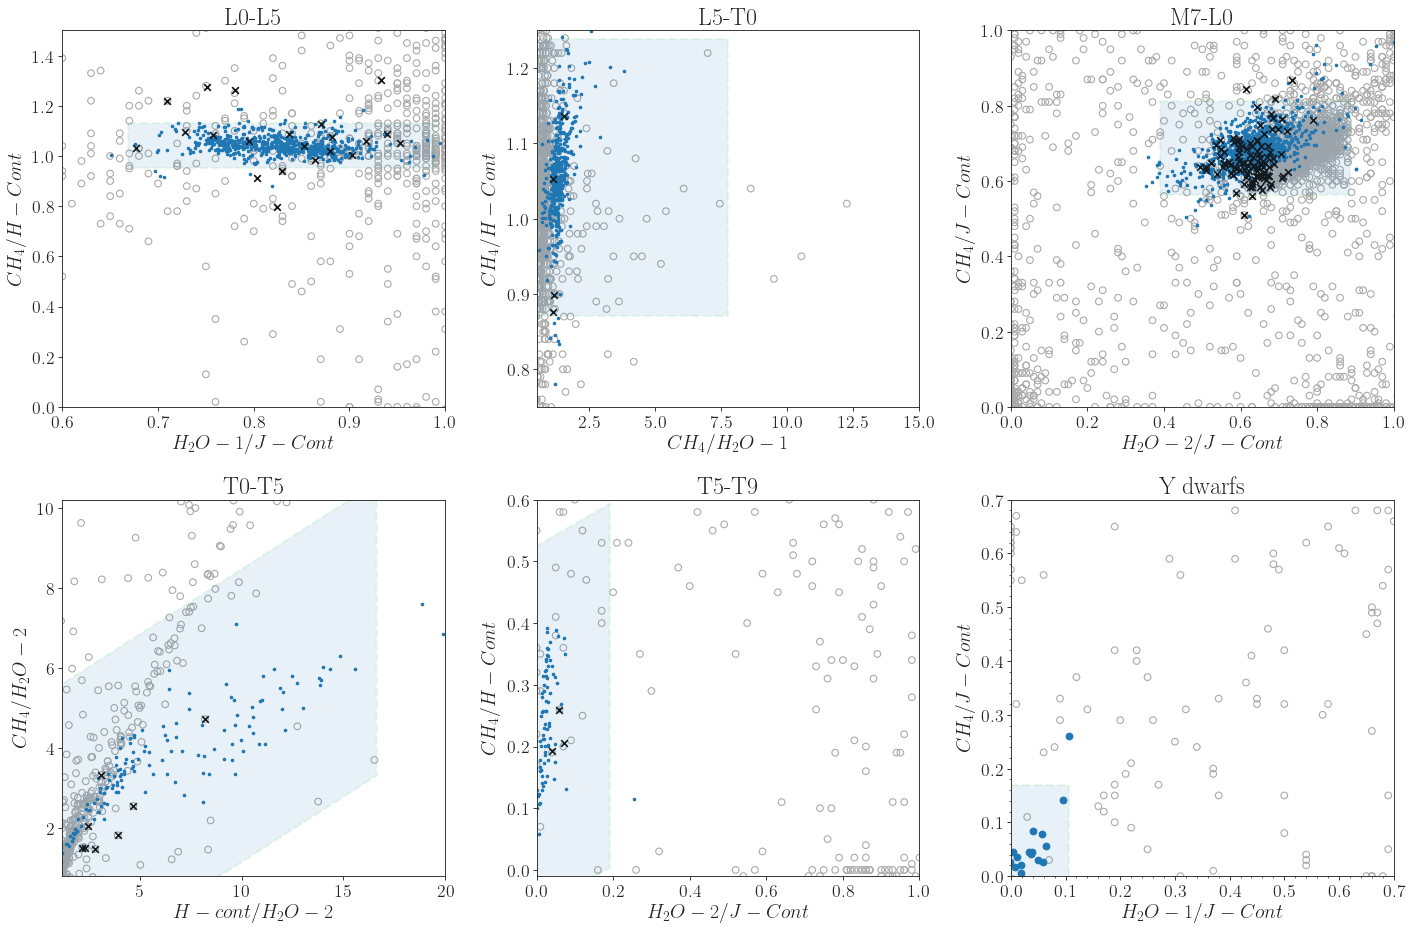

In [27]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(12*1.5, 8*1.5))

good_indices[0].new_plot_best(to_use[good_indices[0].name],ax=ax[0][0], xlim=[0.6, 1.], ylim=[0, 1.5])
good_indices[1].new_plot_best(to_use[good_indices[1].name],ax=ax[0][1],  xlim=[0.5, 15.], ylim=[0.75, 1.25])
good_indices[2].new_plot_best(to_use[good_indices[2].name],ax=ax[0][2], xlim=[0.0,1.0], ylim=[.0, 1.])


good_indices[3].new_plot_best(to_use[good_indices[3].name], ax=ax[1][0], xlim=[1.2, 20.], ylim=[.8, 10.2])
good_indices[4].new_plot_best(to_use[good_indices[4].name],ax=ax[1][1],  xlim=[.0, 1.0], ylim=[-.01, .6])
good_indices[5].new_plot_best(to_use[good_indices[5].name], ax=ax[1][2],  xlim=[0.0, .7], ylim=[0.0, 0.7])


ax[0][0].set_title(to_use[good_indices[0].name])
ax[0][1].set_title(to_use[good_indices[1].name])
ax[0][2].set_title(to_use[good_indices[2].name])

ax[1][0].set_title(to_use[good_indices[3].name])
ax[1][1].set_title(to_use[good_indices[4].name])
ax[1][2].set_title(to_use[good_indices[5].name])

#for a in np.concatenate(ax)[1:]:
#  a.legend().set_visible(False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.pdf', bbox_inches='tight', dpi=200)

### Use these good indices to select objects, ignore f-test

In [28]:
dft=dt.rename(columns={'grism_id':'Names'})

In [29]:
import itertools

In [30]:
cands=[]
for idx, k in zip(good_indices, to_use.keys()):
    spt_range=to_use[k]
    print (spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    df_to_use=wisps.Annotator.reformat_table(dft[[idx.xkey, idx.ykey]])
    selec_indx_array=bx.select(df_to_use).index
    ls=dft.iloc[selec_indx_array].Names
    print (len(np.unique(ls))/len(dft))
    cands.append(ls)

L0-L5
0.04791344667697063
L5-T0
0.39077794951056155
M7-L0
0.4618753219989696
T0-T5
0.6300875837197321
T5-T9
0.006439979392065945
Y dwarfs
0.0005151983513652757


In [31]:
to_use

{'H_2O-1/J-Cont CH_4/H-Cont': 'L0-L5',
 'CH_4/H_2O-1 CH_4/H-Cont': 'L5-T0',
 'H_2O-2/J-Cont CH_4/J-Cont': 'M7-L0',
 'H-cont/H_2O-2 CH_4/H_2O-2': 'T0-T5',
 'H_2O-2/J-Cont CH_4/H-Cont': 'T5-T9',
 'H_2O-1/J-Cont CH_4/J-Cont': 'Y dwarfs'}

In [32]:
merged = np.array(list(itertools.chain(*cands)))

In [33]:
final_cands=np.unique(merged.flatten())

In [34]:
dt[dt.grism_id.isin(np.unique(np.append(final_cands, ls)))].to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [35]:
len(dt[dt.grism_id.isin(np.unique(np.append(final_cands, ls)))])

2632

In [36]:
dfn=dt[dt.grism_id.isin(np.unique(np.append(final_cands, ls)))]

In [37]:
len(dfn)

2632

In [38]:
len(dfn[dfn.spt.apply(splat.typeToNum)>19])

330

In [39]:
dframe=wisps.datasets['candidates']

In [40]:
real_ls=dframe[dframe.spt.apply(splat.typeToNum)>19.]

In [41]:
real_l_index=(dfn[(dfn.spt.apply(splat.typeToNum)>19) & (dfn.grism_id.isin(real_ls.grism_id))])

In [42]:
len(real_l_index)

43

In [43]:
df_rf=wisps.datasets['rf_classified']

In [44]:
df_rf=df_rf[df_rf.spt>19.]

In [45]:
df_rf[df_rf.grism_id.isin(real_ls.grism_id) & ( ~df_rf.grism_id.isin(real_l_index.grism_id))].to_pickle(wisps.LIBRARIES+'/cands_not_indices.pkl')

In [46]:
import seaborn as sns 
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

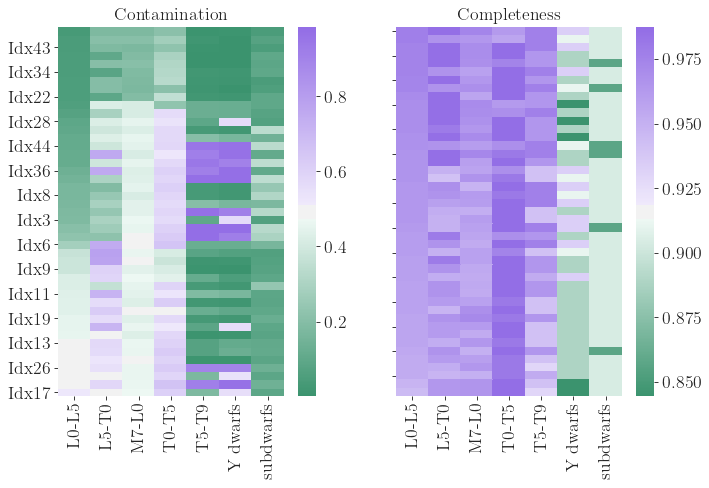

In [47]:
sel_crt.plot_cont_compl(cmap=cmap)

In [48]:
crt_vals=crts.values()
conts=pd.DataFrame([ x.contamination for x in crt_vals]).applymap( lambda x: round(x, 2))
compls=pd.DataFrame([ x.completeness for x in crt_vals]).applymap(lambda x: round(x, 2))
conts['index-space']=[x.name for x in crt_vals]
compls['index-space']=[x.name for x in crt_vals]

In [49]:
conts.to_latex(wisps.LIBRARIES+'/completeness.tex', index=False, na_rep=' ')
conts.to_latex(wisps.LIBRARIES+'/contamination.tex', index=False, na_rep=' ')

In [50]:
#save the indices used here

In [51]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [52]:
df=wisps.datasets['candidates']

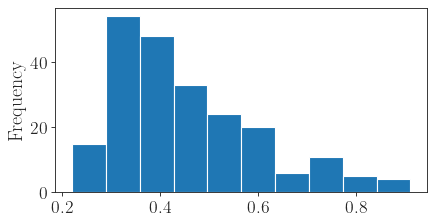

In [53]:
df.f_test.plot(kind='hist')

In [54]:
df1=wisps.Annotator.reformat_table(wisps.datasets['spex'])
df2=wisps.Annotator.reformat_table(wisps.datasets['candidates'])
#df4=wisps.Annotator.reformat_table(wisps.datasets['rf_classified_not_indices'])

In [55]:
xkey=(good_indices[0]).xkey
ykey=(good_indices[0]).ykey

In [56]:
idx=good_indices[0]
bx_name='L0-L5'

bx=[x for x in idx.shapes if x.shape_name=='L0-L5'][0]
slctd=stars.iloc[bx.select((stars[[idx.xkey, idx.ykey]]).applymap(float)).index]

In [57]:
slctd=slctd[slctd.f_test_cdf<0.35]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


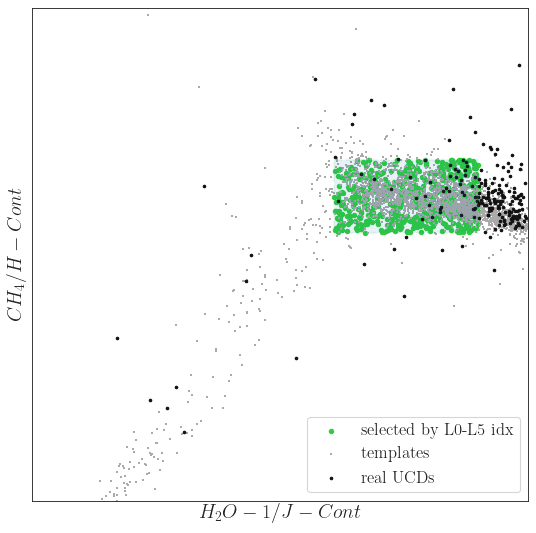

In [58]:
fig, ax=plt.subplots(figsize=(8, 8))
plt.scatter(slctd[xkey].apply(float).values, slctd[ykey].apply(float).values, marker='o',  facecolors='#2ECC40', 
            edgecolors='#2ECC40', s=15, label='selected by L0-L5 idx')
plt.scatter(df1[xkey], df1
            [ykey],marker='+', facecolors='#AAAAAA',  s=5, label='templates')
plt.scatter(df2[xkey].apply(float).values, df2[ykey].apply(float).values, marker='o', 
            facecolors='#111111', s=5, label='real UCDs' )
#plt.scatter(df4[xkey].apply(float).values, df4[ykey].apply(float).values, marker='o',  facecolors='none',   
#            edgecolors='#0074D9', label='selected by RF')
bx.plot(ax=ax)
ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=18)
ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=18)
plt.xticks([])
plt.yticks([])
plt.xlim([0.0, 1.1])
plt.ylim([0.3, 1.5])
plt.legend()
plt.savefig(wisps.OUTPUT_FIGURES+'/Ldwarfs_selection_04.pdf')